# spaTrack's processing of multi-time data

In [1]:
import sys
sys.path.append('/Users/yzf/Desktop/spaTrack')

This notebook uses salamander data at different time points to illustrate spaTrack's processing of multi-time data.

In [2]:
import spaTrack as spt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 150 #分辨率

Load data, including gene expression matrix, cell type annotation, batch, coordinates, cell ID, and gene ID information. Take care that cell type should be placed in `obsm['cluster']` and spatial coordinates should be placed in `obsm['X_spatial']`.

In [3]:
adata=sc.read('/Users/yzf/Desktop/220808_streamplot/data/230307_salamander_mt/exp_count.tsv',cache=True)
adata=adata.T
anno=pd.read_table('/Users/yzf/Desktop/220808_streamplot/data/230307_salamander_mt/cell_annot.tsv',header=None).T
batch=pd.read_table('/Users/yzf/Desktop/220808_streamplot/data/230307_salamander_mt/cell_batch.tsv',header=None).T
coor=pd.read_table('/Users/yzf/Desktop/220808_streamplot/data/230307_salamander_mt/cell_coor.tsv',header=None)
spatial=pd.read_table('/Users/yzf/Desktop/220808_streamplot/data/230307_salamander_mt/pos.ID.tsv',usecols=[1,2])
cell_id=pd.read_table('/Users/yzf/Desktop/220808_streamplot/data/230307_salamander_mt/cell_id.tsv',header=None)
gene_id=pd.read_table('/Users/yzf/Desktop/220808_streamplot/data/230307_salamander_mt/gene_id.tsv',header=None)
adata.obs.index=cell_id[0]
adata.var.index=gene_id[0]
adata.obs['cluster']=anno[0].values
adata.obs['batch']=batch[0].values
adata.obsm['X_umap']=np.array(coor)
adata.obsm['X_spatial']=np.array(spatial)
adata.obs['cluster']=adata.obs['cluster'].replace(['rIPC1','rIPC4'],'rIPC')

Display data from the perspective of spatial transcriptome and single-cell umap.

Text(0.5, 1.0, 'umap (coloring by cluster)')

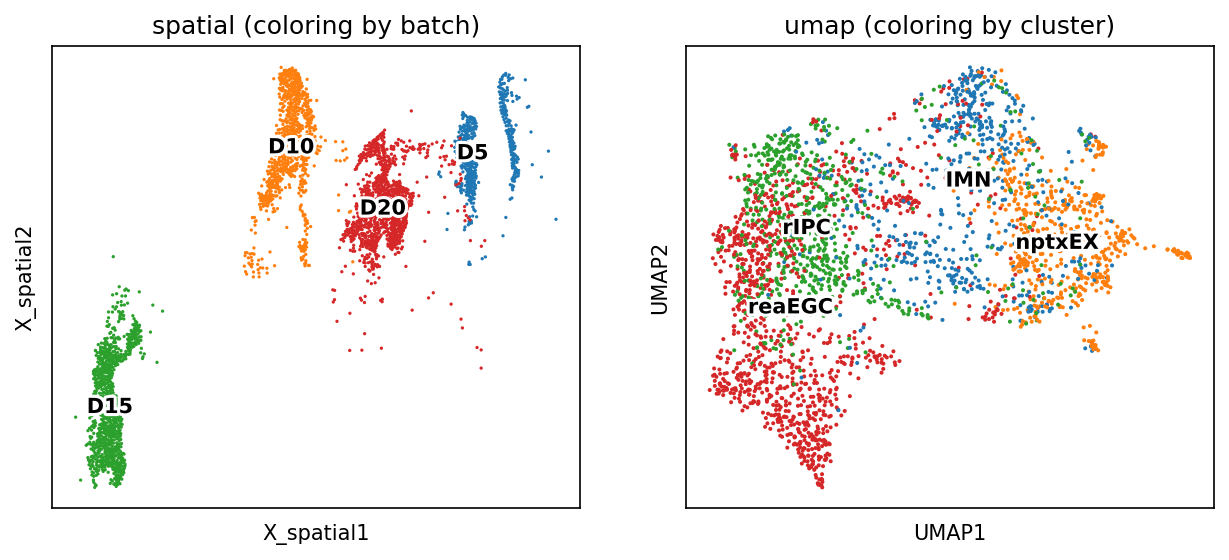

In [4]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
sc.pl.embedding(adata, basis='X_spatial', color='batch', size=20, legend_loc='on data', ax=axs[0], legend_fontoutline=3, show=False, s=10)
axs[0].set_title('spatial (coloring by batch)')
sc.pl.umap(adata,color='cluster',ax=axs[1],legend_loc='on data',legend_fontoutline=3, show=False,s=15)
axs[1].set_title('umap (coloring by cluster)')

For each time point, the starting point is set separately, and the spatial information is used to calculate the cell transition probability and infer the pseudo-timing. 

After that, use the umap embedding to calculate the cell velocity.

In [5]:
time_and_start = {
    'D5': 'reaEGC',
    'D10': 'reaEGC',
    'D15': 'reaEGC',
    'D20': 'rIPC'
}
P_all = V_all = np.array([]).reshape(0, 2)

for time in time_and_start.keys():
    print(time)
    subadata = adata[adata.obs['batch'] == time]
    subadata.obsp['trans'] = spt.get_ot_matrix(subadata, data_type='spatial')
    start_cluster = time_and_start[time]
    start_cells = spt.set_start_cells(subadata, select_way='cell_type', cell_type=start_cluster)
    subadata.obs['ptime'] = spt.get_ptime(subadata, start_cells)
    _, _ = spt.get_velocity(subadata,basis='umap', n_neigh_pos=80, n_neigh_gene=0)

    P_all = np.vstack((P_all, subadata.obsm['X_umap']))
    V_all = np.vstack((V_all, subadata.obsm['velocity_umap']))

D5
X_pca is not in adata.obsm, automatically do PCA first.
The velocity of cells store in 'velocity_umap'.
D10
X_pca is not in adata.obsm, automatically do PCA first.
The velocity of cells store in 'velocity_umap'.
D15
X_pca is not in adata.obsm, automatically do PCA first.
The velocity of cells store in 'velocity_umap'.
D20
X_pca is not in adata.obsm, automatically do PCA first.
The velocity of cells store in 'velocity_umap'.


Convert cell velocity to grid velocity for subsequent streamplot. Cell velocity is only calculated from neighbor cells at the same time point.

In [6]:
P_grid, V_grid = spt.get_velocity_grid(
    adata, P=P_all, V=V_all
)

Display cell trajectories at the umap level.

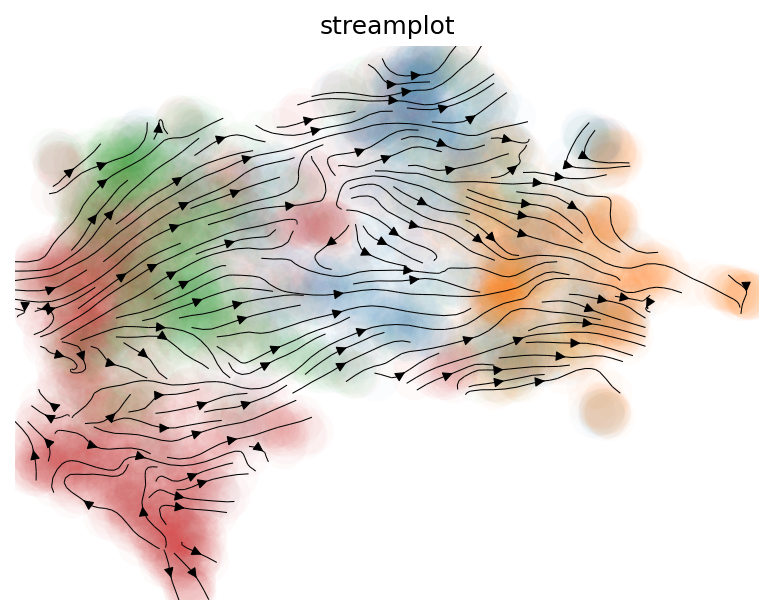

In [7]:
vf_velocity = sc.pl.embedding(adata, basis='X_umap', show=False,color='cluster', legend_loc=None, frameon=False, title='streamplot', alpha=0.02, size=2000)
vf_velocity.streamplot(*P_grid,*V_grid,color='black', linewidth=0.5,density=2,)